This notebook acn be used to compare results from different models

In [52]:
from google.colab import drive
import os
import pickle
import tensorflow_gcs_config
import shutil
import numpy as np

import tensorflow as tf
from matplotlib import pyplot as plt
import nibabel as nib
import tensorflow_hub as hub
drive.mount('/content/MyDrive/')
os.chdir('/content/MyDrive/MyDrive/IDS705_Final') #change to file path on your disk

Drive already mounted at /content/MyDrive/; to attempt to forcibly remount, call drive.mount("/content/MyDrive/", force_remount=True).


In [53]:
#Create Train / Val / Test Split
subfolders = os.listdir("Data/Train")
np.random.seed(101)
split = np.random.choice(["Train","Val","Test"], len(subfolders), p=[0.6, 0.2, 0.2])
train_ids = [subfolders[i] for i,v in enumerate(split) if v=="Train"]
val_ids = [subfolders[i] for i,v in enumerate(split) if v=="Val"]
test_ids = [subfolders[i] for i,v in enumerate(split) if v=="Test"]

In [54]:
#Helper Functions

def parse_tfrecord(example):
  """
  This function helps in parsing tfrecord files when creating a TF Dataset object
  """
  feature = {'image': tf.io.FixedLenFeature([240, 240, 155, 4], tf.float32),
             'label': tf.io.FixedLenFeature([240, 240, 155], tf.int64)}
  parsed_example = tf.io.parse_single_example(example, feature)
  return parsed_example

def get_image_and_label(features):
  """
  Extract Image and Label Object from tfrecord files
  """
  image, label = features['image'], features['label']
  return image, label

def get_dataset(tfrecord_names):
  """
  Create TF dataset files that can be fed into model functions
  """
  dataset = (tf.data.TFRecordDataset(tfrecord_names, num_parallel_reads=8)
             .map(parse_tfrecord)
             .map(get_image_and_label))

  return dataset

In [97]:
# Ref: salehi17, "Twersky loss function for image segmentation using 3D FCDN"
# -> the score is computed for each class separately and then summed
# alpha=beta=0.5 : dice coefficient
# alpha=beta=1   : tanimoto coefficient (also known as jaccard)
# alpha+beta=1   : produces set of F*-scores
# implemented by E. Moebel, 06/04/18

# class iou(tf.keras.losses.Loss):

#   def call(self, y_true, y_pred):
#     alpha = 0.5 
#     beta = 0.5
#     all_except_last_dims = (0,1,2,3)
#     y_true = tf.one_hot(y_true,5)
#     ones = 1#tf.ones(y_true.shape)
#     p0 = y_pred      # proba that voxels are class i
#     p1 = ones-y_pred # proba that voxels are not class i
#     g0 = y_true
#     g1 = ones-y_true
#     num = tf.math.reduce_sum(p0*g0, all_except_last_dims)
#     den = num + alpha*tf.math.reduce_sum(p0*g1, all_except_last_dims) + beta*tf.math.reduce_sum(p1*g0, all_except_last_dims)
#     T = tf.math.reduce_sum(num/den)
#     Ncl = tf.cast(tf.shape(y_true)[-1], 'float32')
#     return Ncl - T

from keras import backend as K

class dice(tf.keras.losses.Loss):
  def dice_coef(self, y_true, y_pred, smooth=1):
      """
      Dice = (2*|X & Y|)/ (|X|+ |Y|)
          =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
      ref: https://arxiv.org/pdf/1606.04797v1.pdf
      """
      y_true = tf.one_hot(y_true,5)
      intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
      return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

  def call(self, y_true, y_pred):
      return 1-self.dice_coef(y_true, y_pred)
    
class ioumetric(tf.keras.metrics.Mean):
    def __init__(self,  indices, **kwargs):
        super().__init__(**kwargs)
        self.score = tf.zeros(5)
        pass

    def dice_coef(self, y_true, y_pred, smooth=0):
        intersection = K.sum(K.abs(y_true * y_pred))
        union =  (K.sum(K.square(y_true)) + K.sum(K.square(y_pred)) + smooth)
        return (2*intersection/union)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.one_hot(y_true,5)
        intersection = K.sum(K.abs(y_true * y_pred), axis=(0,1,2,3))
        union =  (K.sum(K.square(y_true), axis=(0,1,2,3)) + K.sum(K.square(y_pred), axis=(0,1,2,3)))
        self.score =  2*intersection/union
 
    def result(self):
        return self.score
        


In [99]:
#Create dataset objects
val_dataset = get_dataset([f'Data/train_tf/{sf}.tfrecord' for sf in val_ids])
test_dataset = get_dataset([f'Data/train_tf/{sf}.tfrecord' for sf in test_ids])

Load the saved models

In [57]:
models_list = {}
models_list['bce'] = tf.keras.models.load_model('/content/MyDrive/MyDrive/IDS705_Final/Models/Models_03_20ep') #This model used the incorrect architecture with CrossEntropy as the loss function. LR = 3e-4
models_list['dice'] = tf.keras.models.load_model('/content/MyDrive/MyDrive/IDS705_Final/Models/Modelsgpu_05_20ep', custom_objects={'dice': dice}) #This model used the corrected architecture with DICE as the loss function. LR=5e-4

Get Metric Evaluations

In [100]:
models_list['bce'].compile(optimizer=tf.keras.optimizers.Adam(), metrics = [ioumetric(indices=[1,2,4])] )
models_list['bce'].evaluate(test_dataset.batch(4))

66/66 [==============================] - 244s 3s/step - loss: 0.0000e+00 - mean: 0.3625


[0.0, array([0.99869156, 0.15123175, 0.5087712 , 0.        , 0.15393649],
       dtype=float32)]

In [101]:
models_list['dice'].compile(optimizer=tf.keras.optimizers.Adam(), metrics = [ioumetric(indices=[1,2,4])] )
models_list['dice'].evaluate(test_dataset.batch(4))

66/66 [==============================] - 249s 3s/step - loss: 0.0000e+00 - mean: 0.3258


[0.0, array([0.99829495, 0.07960552, 0.5253432 , 0.        , 0.02591646],
       dtype=float32)]

Visualize predictions

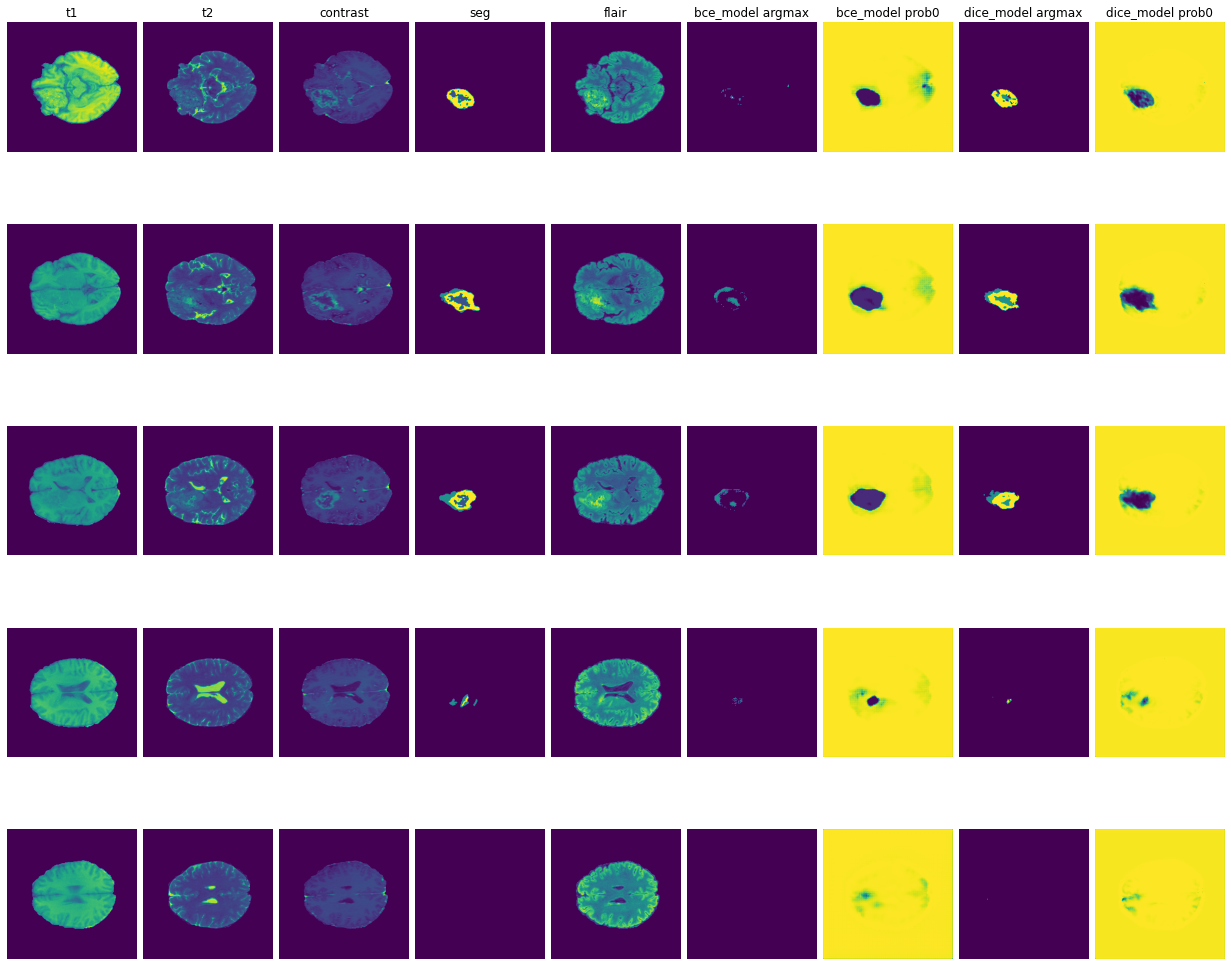

In [ ]:
plt.rcParams['axes.xmargin'] = 0

i=200 #Max value = 243

minipred_dataset = get_dataset([f'/content/MyDrive/MyDrive/IDS705_Final/Data/train_tf/{sf}.tfrecord' for sf in val_ids[i:(i+1)]])
minipred_dataset = minipred_dataset.batch(1)

preds = {k: models_list[k].predict(minipred_dataset, batch_size=4) for k in models_list.keys()}
n_models = len(models_list)

subfolder_name = val_ids[i]
img1 = nib.load(f'Data/Train/{subfolder_name}/{subfolder_name}_t1.nii.gz') 
img2 = nib.load(f'Data/Train/{subfolder_name}/{subfolder_name}_t2.nii.gz') 
imgce = nib.load(f'Data/Train/{subfolder_name}/{subfolder_name}_t1ce.nii.gz') 
imgseg = nib.load(f'Data/Train/{subfolder_name}/{subfolder_name}_seg.nii.gz') 
imgflair = nib.load(f'Data/Train/{subfolder_name}/{subfolder_name}_flair.nii.gz') 

slices = [60,70,80,90,100] #Change Slices to look at here

fig,axs = plt.subplots(len(slices), 5+ 2*n_models, figsize=(18,15))
for j,slice_no in enumerate(slices):
    axs[j,0].imshow(img1.dataobj[:,:,slice_no])
    axs[j,1].imshow(img2.dataobj[:,:,slice_no])
    axs[j,2].imshow(imgce.dataobj[:,:,slice_no])
    axs[j,3].imshow(imgseg.dataobj[:,:,slice_no])
    axs[j,4].imshow(imgflair.dataobj[:,:,slice_no])
    for ik,k in enumerate(preds.keys()):
        axs[j,5 + ik*2].imshow(preds[k][0,:,:,slice_no,:].argmax(2))
        axs[j,6 + ik*2].imshow(preds[k][0,:,:,slice_no,0])
        axs[0,5 + ik*2].set_title(k+"_model argmax")
        axs[0,6 + ik*2].set_title(k+"_model prob0")
    for jj in range(5+2*n_models):
      axs[j,jj].axis('off')

axs[0,0].set_title("t1")
axs[0,1].set_title("t2")
axs[0,2].set_title("contrast")
axs[0,3].set_title("seg")
axs[0,4].set_title("flair")
fig.tight_layout()



fig.subplots_adjust(
    top=0.981,
    bottom=0.049,
    left=0.042,
    right=0.981,
    hspace=0.01,
    wspace=0.05,
)